# Info
The notebook downloaded from https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LSTM%20Time%20Series%20Power%20Consumption.ipynb and then modified.

Most commented kernel on Kaggle: https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


The data is the measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available. However, we are only interested in Global_active_power variable. 

In [3]:
df = pd.read_csv('../../data/raw/household_power_consumption.csv', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [18]:
print("Stats on rows with missing data:")
print(df.isnull().sum())
print()
print(f"Rows with missing data: {df.isnull().sum().sum()*100 / df.shape[0]:.4f}%")

Stats on rows with missing data:
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Rows with missing data: 1.2518%


Approx 1.2% of value in `Sub_metering_3` column are missing, it is not a big deal, I decided to remove them.

In [19]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(2049280, 7)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


In [20]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


After removing the missing values, the data contains 2049280 measurements gathered between December 2006 and December 2010 (48 months).

The initial data contains several variables. We will here focus on a single value : a house's Global_active_power history, that is, household global minute-averaged active power in kilowatt.

### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [21]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 4.218671866132129
Skewness of normal distribution: 1.7862320846320843


Matplotlib is building the font cache using fc-list. This may take a moment.


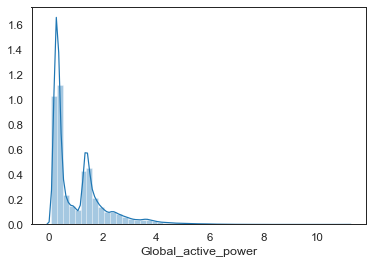

In [22]:
# print(df.Global_active_power.describe())
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

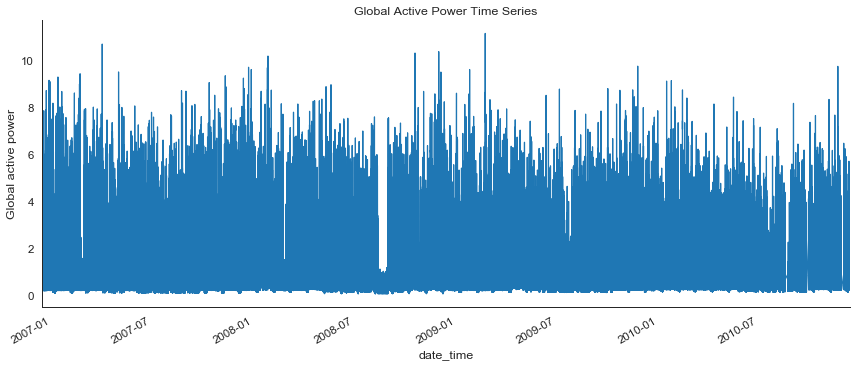

In [23]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

Apparently, this plot is not a good idea. Don't do this.

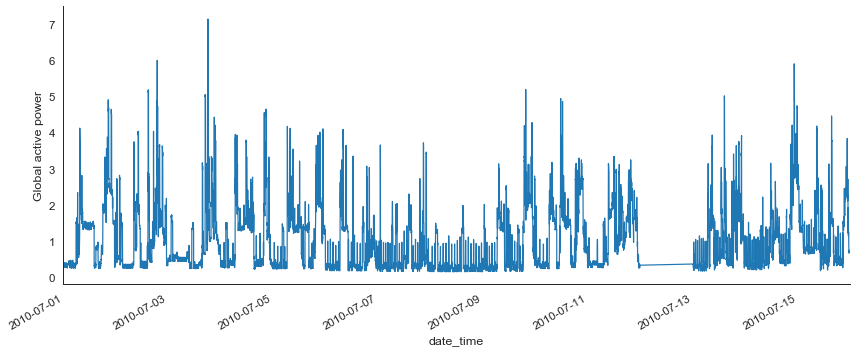

In [24]:
df2=df1[(df1.index>='2010-07-01') & (df1.index<'2010-7-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### Box plot of yearly vs. quarterly Global active power

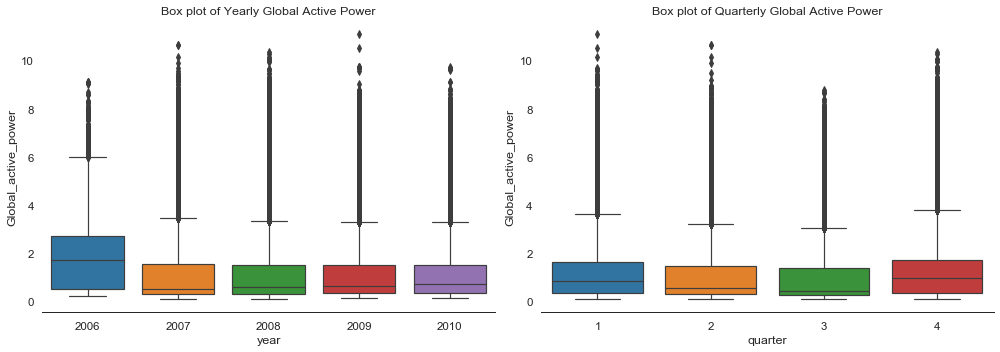

In [25]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

When we compare boxplot side by side for each year, we notice that the median global active power in 2006 is much higher than the other years'. This is a little bit misleading. If you remember, we only have December data for 2006. While apparently December is the peak month for household electric power consumption. 

This is consistent with the quarterly median global active power, it is higher in the 1st and 4th quarters (winter), and it is the lowest in the 3rd quarter (summer).

### Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


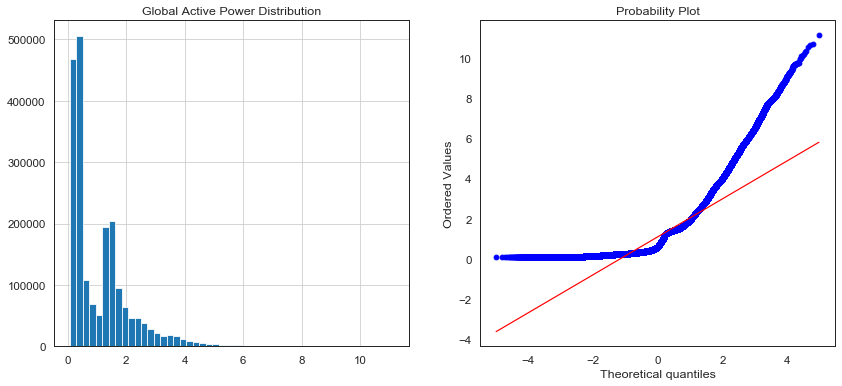

In [26]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df1.describe().T

Normal probability plot also shows the data set is far from normally distributed.

### Average Global Active Power resampled over day, week, month, quarter and year.

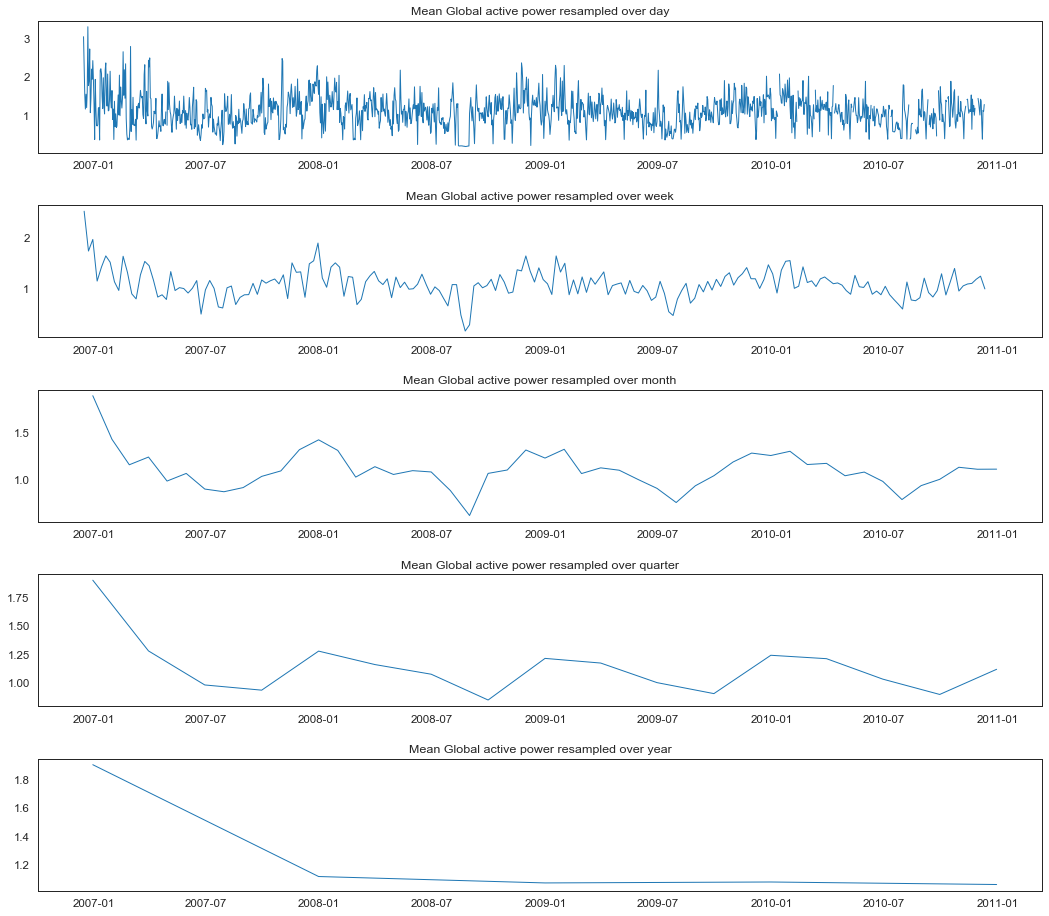

In [27]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

In general, our time series does not have a general upward or downward trend. The highest average power consumption was prior to 2007, it decreased significantly in one year until early 2008, and has been steady since then.

### Plot mean global active power grouped by year, quarter, month and day.

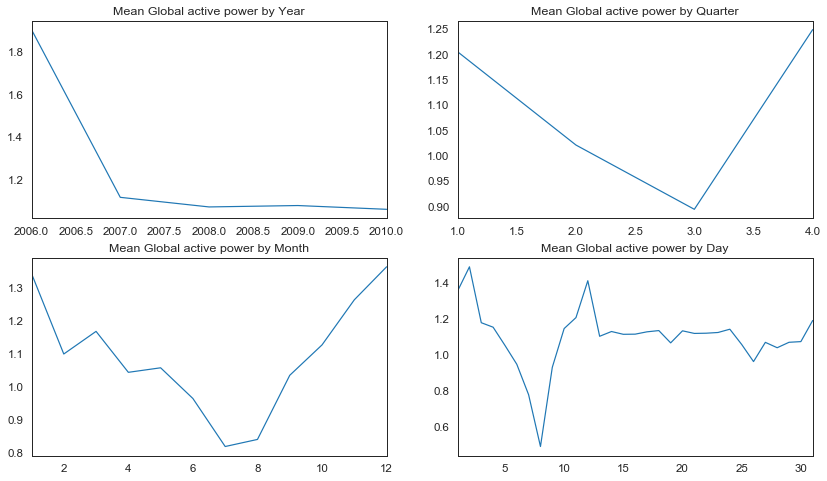

In [28]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

The above plots confirmed our previous discoveries. By year, the highest average power consumption was prior to 2007, and it has been consistent since then. By quarter, the lowest average power consumption was in the 3rd quarter. By month, the lowest average power consumption was in July and August. By day, the lowest average power consumption was around 8th of the month (don't know why). 

### Global Active Power by Years

For 2006, we only have data for December, so remove 2006.

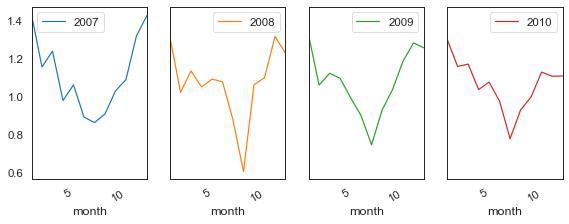

In [29]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

### Global active power consumption in Weekdays vs. Weekends

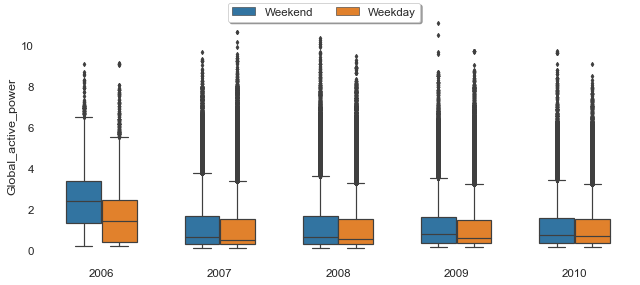

In [30]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median global active power in weekdays seems to be lower than the weekends prior to 2010.

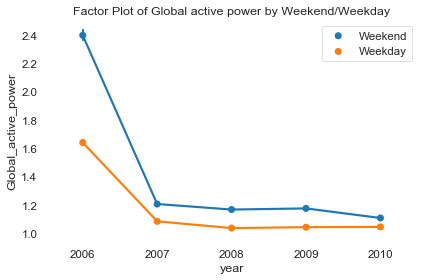

In [31]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Both weekdays and weekends have the similar trends over year.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [32]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

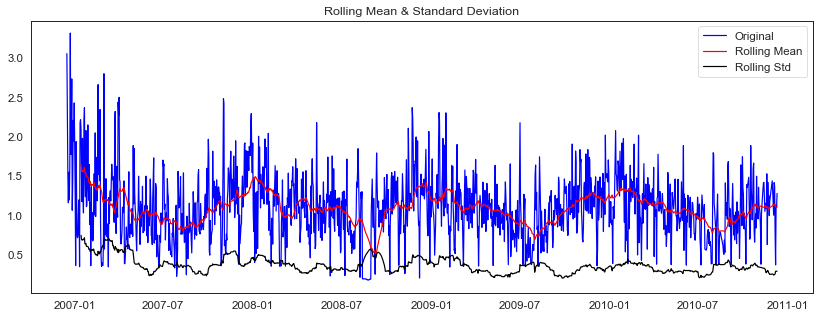

<Results of Dickey-Fuller Test>
Test Statistic                  -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of Observations Used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [33]:
test_stationarity(df2.Global_active_power.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM

The task here will be to predict values for a timeseries given the history of 2 million minutes of a household's power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minutes.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [34]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [36]:
print(train.shape, test.shape)

(1639424, 1) (409856, 1)


In [37]:
print(train[0])
print(test[0])

[0.37479633]
[0.35596597]


In [35]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [38]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [41]:
print(X_train.shape, Y_train.shape)

(1639393, 30) (1639393,)


In [42]:
print(X_test.shape, Y_test.shape)

(409825, 30) (409825,)


In [43]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [44]:
print(X_train.shape, X_test.shape)

(1639393, 1, 30) (409825, 1, 30)


### Model Architecture

In [45]:
X_train.shape

(1639393, 1, 30)

In [46]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 64s 39us/step - loss: 7.7526e-04 - val_loss: 4.2709e-04
Epoch 2/20
1639393/1639393 [==============================] - 64s 39us/step - loss: 6.6558e-04 - val_loss: 4.5848e-04
Epoch 3/20
1639393/1639393 [==============================] - 69s 42us/step - loss: 6.5409e-04 - val_loss: 4.5534e-04
Epoch 4/20
1639393/1639393 [==============================] - 66s 40us/step - loss: 6.4644e-04 - val_loss: 4.4946e-04
Epoch 5/20
1639393/1639393 [==============================] - 66s 40us/step - loss: 6.4178e-04 - val_loss: 4.5486e-04
Epoch 6/20
1639393/1639393 [==============================] - 67s 41us/step - loss: 6.3965e-04 - val_loss: 4.5046e-04
Epoch 7/20
1639393/1639393 [==============================] - 68s 41us/step - loss: 6.3621e-04 - val_loss: 4.3572e-04
Epoch 8/20
1639393/1639393 [==============================] - 68s 41us/step - loss: 6.3482e-04 - val_loss: 4.4247e-04
Epo

In [47]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11844412197302595
Train Root Mean Squared Error: 0.26954101528526025
Test Mean Absolute Error: 0.10544536016514613
Test Root Mean Squared Error: 0.22445404370658673


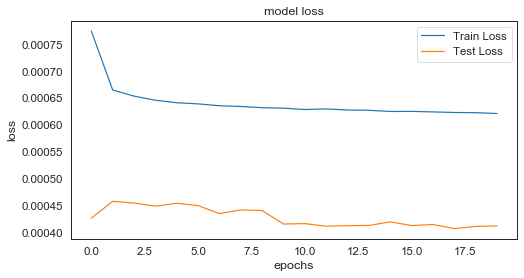

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

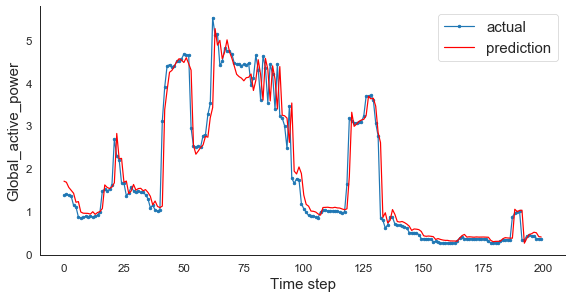

In [49]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();